# EDA (Exploratory Data Analysis) of Raw Cityscapes Dataset

In this notebook, we explore the raw semantic segmentation data provided through the class `torchvision.datasets.Cityscapes`. The findings informed our design of the custom class `data.cityscapes.SparseLabelSimulatingDataset`, which we use in all other scripts and notebooks.

https://www.cityscapes-dataset.com/  
https://www.cityscapes-dataset.com/dataset-overview/#class-definitions  
https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task  
https://www.cityscapes-dataset.com/downloads/  
https://www.cityscapes-dataset.com/create-submission/  

https://pypi.org/project/cityscapesScripts/  
https://github.com/mcordts/cityscapesScripts  
https://pytorch.org/vision/stable/generated/torchvision.datasets.Cityscapes.html#torchvision.datasets.Cityscapes

In [1]:
# Standard
import os
from pprint import pprint
import time
from typing import Dict, List, Tuple

# Numerics
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Image Processing
import imageio.v3 as imageio

# Machine Learning
import torch
#from torch.utils.data import Dataset
# `Cityscapes` is defined in
# `segmentation-with-sparse-labels/segmentation-with-sparse-labels-env/lib/python3.9/site-packages/torchvision/datasets/cityscapes.py`.
from torchvision.datasets import Cityscapes
# `cityscapesscripts` is defined in
# `segmentation-with-sparse-labels-env/lib/python3.9/site-packages/cityscapesscripts/`
#import cityscapesscripts

In [2]:
# Project-Specific
from core import (
    eda,
    SemanticClassId,
)
from core.visualization import (
    scale_plot_size,
    show_image,
    overlay_segmentation_map_rgb,
    plot_grid_of_images,
    construct_segmentation_side_by_sides,
)
from data.cityscapes import class_mapping

In [3]:
scale_plot_size(factor=1.8)

In [4]:
# Manually seed for reproducibility.
np.random.seed(13)
torch.manual_seed(13)

In [5]:
REPO_ROOT: str = os.environ.get("REPO_ROOT")
assert REPO_ROOT is not None, \
    "REPO_ROOT not found! Did you run `setenv.sh` before serving the notebook?"
data_root_dirname: str = os.path.join(REPO_ROOT, "data/cityscapes")

In [6]:
!ls -Fal {data_root_dirname}

total 11567320
drwxr-xr-x 4 karl karl        4096 Jan  1 19:48 ./
drwxr-xr-x 3 karl karl        4096 Jan  1 19:48 ../
-rw-r--r-- 1 karl karl           0 Jan  1 19:29 .gitkeep
drwxr-xr-x 5 karl karl        4096 Jan  1 19:48 gtFine/
-rw-r--r-- 1 karl karl   252567705 Mar 21  2016 gtFine_trainvaltest.zip
drwxr-xr-x 5 karl karl        4096 Jan  1 19:49 leftImg8bit/
-rw-r--r-- 1 karl karl 11592327197 Mar 21  2016 leftImg8bit_trainvaltest.zip
-rw-r--r-- 1 karl karl        1646 Feb 17  2016 license.txt
-rw-r--r-- 1 karl karl         298 Feb 20  2016 README


---

## Load Datasets and Compute Aggregate Statistics

In [7]:
dataset_train: Cityscapes = Cityscapes(
    root=data_root_dirname,
    split="train",  # "train", "val, "test"
    mode="fine",
    target_type="semantic",
    transform=None,
    target_transform=None,
    transforms=None,
)

dataset_val: Cityscapes = Cityscapes(
    root=data_root_dirname,
    split="val",  # "train", "val, "test"
    mode="fine",
    target_type="semantic",
    transform=None,
    target_transform=None,
    transforms=None,
)

dataset_test: Cityscapes = Cityscapes(
    root=data_root_dirname,
    split="test",  # "train", "val, "test"
    mode="fine",
    target_type="semantic",
    transform=None,
    target_transform=None,
    transforms=None,
)

In [8]:
Cityscapes.mro()

[torchvision.datasets.cityscapes.Cityscapes,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object]

In [9]:
num_images_train: int = len(dataset_train.images)
num_images_val: int = len(dataset_val.images)
num_images_test: int = len(dataset_test.images)
num_images_total: int = num_images_train + num_images_val + num_images_test
print(f"  Number of training images: {num_images_train}")
print(f"Number of validation images: {num_images_val}")
print(f"      Number of test images: {num_images_test}")
print("-------------------------------------")
print(f"     Total number of images: {num_images_total}")

  Number of training images: 2975
Number of validation images: 500
      Number of test images: 1525
-------------------------------------
     Total number of images: 5000


---

## Training Dataset Detailed Examination

In [10]:
dataset: Cityscapes = dataset_train
ixs_shuffled: List[int] = list(range(len(dataset)))
np.random.shuffle(ixs_shuffled)

In [11]:
print("\nDataset MRO (Model Resolution Order):")
print(type(dataset).mro())

print("\nDataset public attributes:")
eda.pdir(dataset, include_magic=False, include_private=False)

print("\nRaw segmentation map type:")
print(type(dataset[0][1]))


Dataset MRO (Model Resolution Order):
[<class 'torchvision.datasets.cityscapes.Cityscapes'>, <class 'torchvision.datasets.vision.VisionDataset'>, <class 'torch.utils.data.dataset.Dataset'>, <class 'typing.Generic'>, <class 'object'>]

Dataset public attributes:
['CityscapesClass',
 'classes',
 'extra_repr',
 'images',
 'images_dir',
 'mode',
 'root',
 'split',
 'target_transform',
 'target_type',
 'targets',
 'targets_dir',
 'transform',
 'transforms']

Raw segmentation map type:
<class 'PIL.PngImagePlugin.PngImageFile'>


In [12]:
attribute_name: str = "images"
print(f"\nDataset.{attribute_name}:")
eda.inspect_dataset_list_attribute(dataset, attribute_name)


Dataset.images:
type(value): <class 'list'>
type(value[0]): <class 'str'>
len(value): 2975
value:
/home/karl/karl/fast-karl/git_repos/image-segmentation-with-sparse-labels/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000030_000019_leftImg8bit.png
/home/karl/karl/fast-karl/git_repos/image-segmentation-with-sparse-labels/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000146_000019_leftImg8bit.png
/home/karl/karl/fast-karl/git_repos/image-segmentation-with-sparse-labels/data/cityscapes/leftImg8bit/train/dusseldorf/dusseldorf_000082_000019_leftImg8bit.png
.
.
.



In [13]:
# Collect and print image dimension statistics.
num_images_ubnd: int = 5000
num_images: int = min(num_images_ubnd, len(dataset))
image_filenames: List[str] = \
    [ dataset.images[ix] for ix in ixs_shuffled[:num_images] ]

start_time: float = time.time()
images_shape_stats: eda.ImagesShapeStats = \
    eda.ImagesShapeStats(image_filenames)
print(f"Examined dimensions of {num_images} images.")
print(f"Elapsed time = {time.time() - start_time:.2f} s")

images_shape_stats.print_summary()

Examined dimensions of 2975 images.
Elapsed time = 27.48 s
+--------+--------+-------+-----------------------------+
|        | height | width | aspect ratio (width:height) |
+========+========+=======+=============================+
|   mean |  1024  | 2048  |              2              |
+--------+--------+-------+-----------------------------+
| median |  1024  | 2048  |              2              |
+--------+--------+-------+-----------------------------+
|    min |  1024  | 2048  |              2              |
+--------+--------+-------+-----------------------------+
|    max |  1024  | 2048  |              2              |
+--------+--------+-------+-----------------------------+


In [14]:
attribute_name: str = "targets"
print(f"\nDataset.{attribute_name}:")
eda.inspect_dataset_list_attribute(dataset, attribute_name)


Dataset.targets:
type(value): <class 'list'>
type(value[0]): <class 'list'>
len(value): 2975
value:
['/home/karl/karl/fast-karl/git_repos/image-segmentation-with-sparse-labels/data/cityscapes/gtFine/train/dusseldorf/dusseldorf_000030_000019_gtFine_labelIds.png']
['/home/karl/karl/fast-karl/git_repos/image-segmentation-with-sparse-labels/data/cityscapes/gtFine/train/dusseldorf/dusseldorf_000146_000019_gtFine_labelIds.png']
['/home/karl/karl/fast-karl/git_repos/image-segmentation-with-sparse-labels/data/cityscapes/gtFine/train/dusseldorf/dusseldorf_000082_000019_gtFine_labelIds.png']
.
.
.



Random data index chosen: 1372
/home/karl/karl/fast-karl/git_repos/image-segmentation-with-sparse-labels/data/cityscapes/leftImg8bit/train/hanover/hanover_000000_023614_leftImg8bit.png
type: <class 'numpy.ndarray'>
dtype: uint8
shape: (1024, 2048, 3)


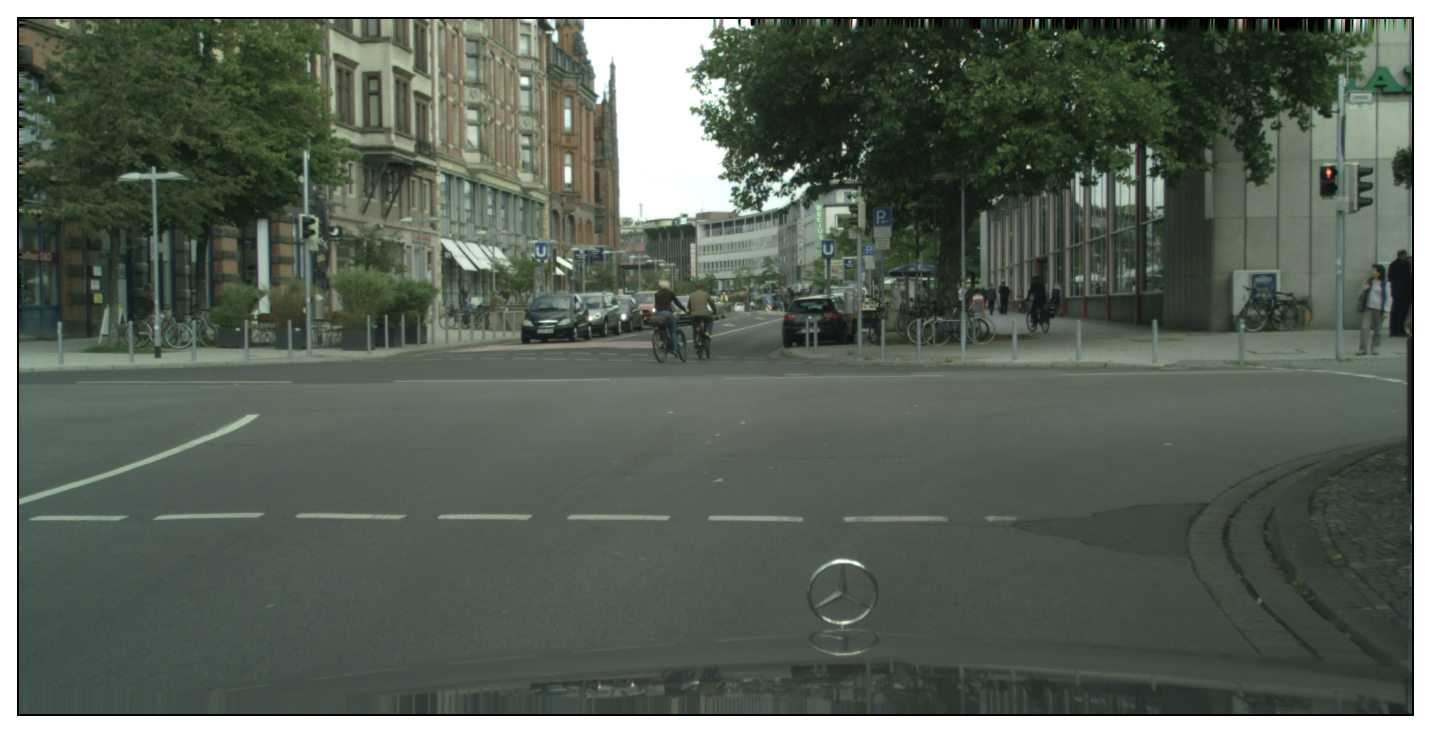

In [15]:
# Plot a random image.
ix: int = ixs_shuffled[0]
print(f"Random data index chosen: {ix}")
image_filename: str = dataset.images[ix]
print(image_filename)
image: np.ndarray = imageio.imread(image_filename)
eda.print_image_metadata(image)
show_image(image)

/home/karl/karl/fast-karl/git_repos/image-segmentation-with-sparse-labels/data/cityscapes/gtFine/train/hanover/hanover_000000_023614_gtFine_labelIds.png
type: <class 'numpy.ndarray'>
dtype: uint8
shape: (1024, 2048, 3)


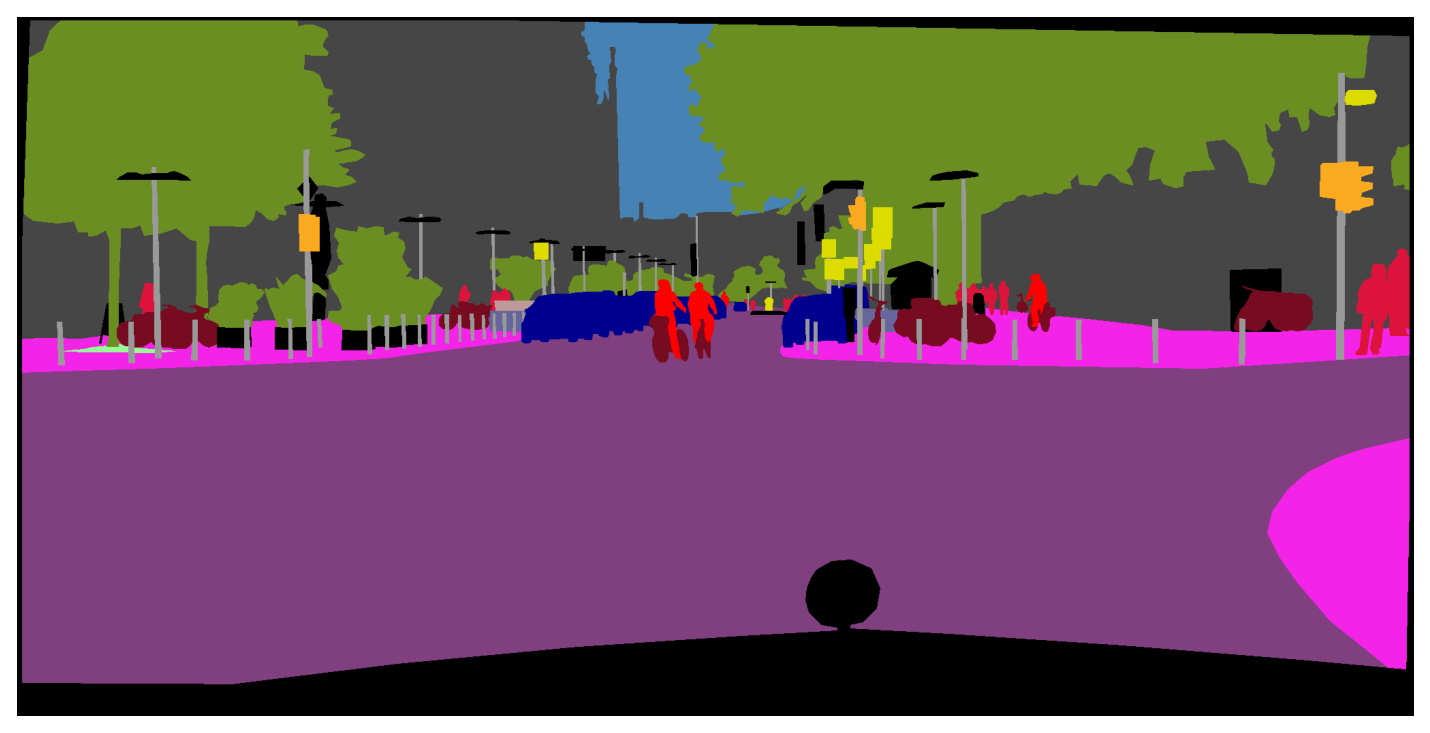

In [16]:
# Load and plot segmentation map from targets.

# Cityscapes raw mask pixels are segmentation class IDs (not RGB).
target_filename: str = dataset.targets[ix][0]

segmentation_map_int_raw: np.ndarray = imageio.imread(target_filename)
segmentation_map_int: np.ndarray = \
    class_mapping.segmentation_map_int_from_raw(segmentation_map_int_raw)
segmentation_map_rgb: np.ndarray = \
    class_mapping.segmentation_map_rgb_from_int(segmentation_map_int)

print(target_filename)
eda.print_image_metadata(segmentation_map_rgb)
show_image(segmentation_map_rgb)

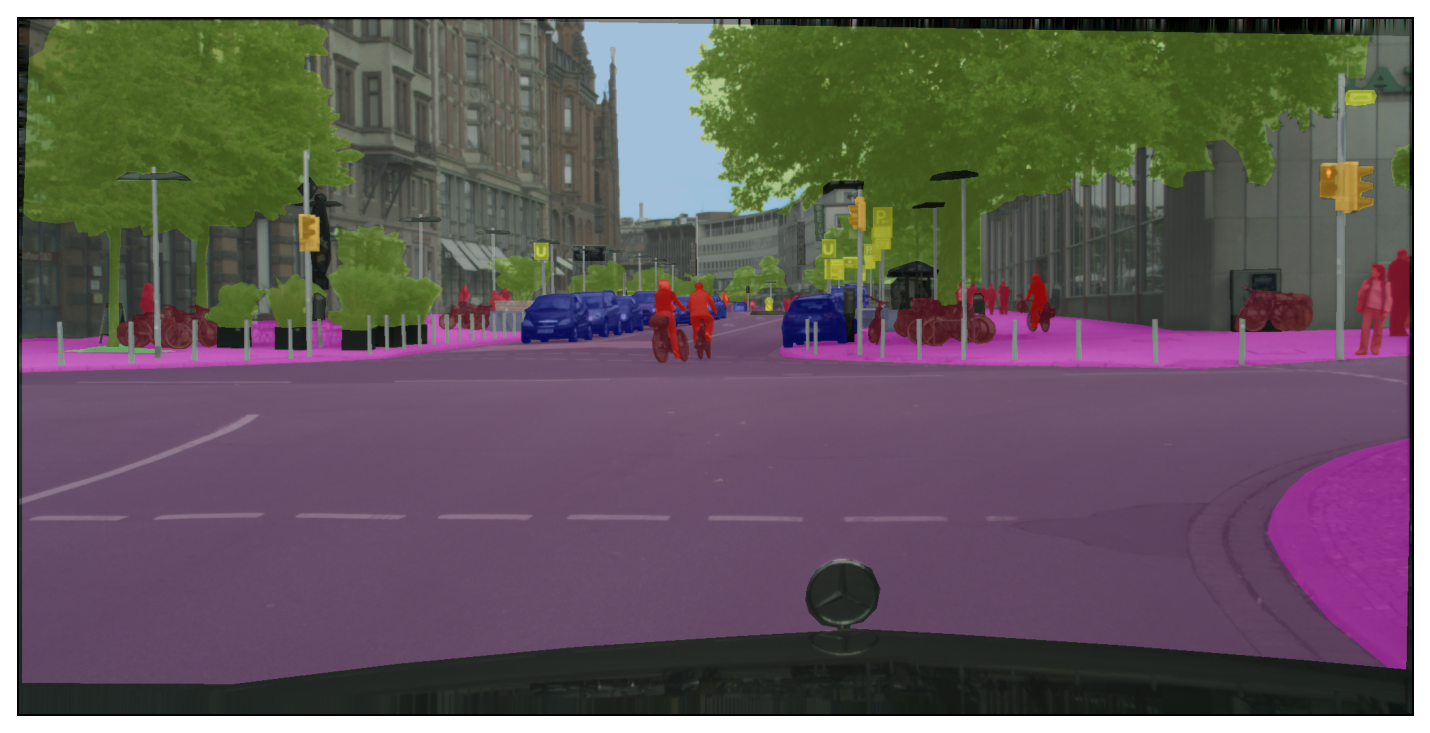

In [17]:
# Translucent overlay via alpha compositing.
image_with_overlay: np.ndarray = \
    overlay_segmentation_map_rgb(image, segmentation_map_rgb, alpha=0.5)
show_image(image_with_overlay)

In [18]:
# Collect and print raw segmentation class statistics from the targets.

# The entire training set contains exactly the raw class IDs [0, 1, 2,..., 33].
# Running with `num_images_ubnd=500` gives at least 1 example of each.
num_images_ubnd: int = 5000
num_images: int = min(num_images_ubnd, len(dataset))
filenames: List[str] = \
    [ dataset.targets[ix][0] for ix in ixs_shuffled[:num_images] ]

start_time: float = time.time()
segmentation_maps_joint_pixel_stats: eda.SegmentationMapsJointPixelStats = \
    eda.SegmentationMapsJointPixelStats(
        segmentation_map_filenames=filenames,
        segmentation_map_int_from_raw=None,
    )
print(f"Examined the pixel labels of {num_images} images.")
print(f"Elapsed time = {time.time() - start_time:.2f} s")

class_id_names: Dict[SemanticClassId, str] = {
    class_.id: class_.name  for class_ in dataset.classes
}
segmentation_maps_joint_pixel_stats.print_summary(class_id_names)

Examined the pixel labels of 2975 images.
Elapsed time = 115.75 s
+----------+--------------------+-----------+----------+-----------+-----------+
| class ID |     class name     | # pixels  | # images |  portion  |  portion  |
|          |                    |           |          | of pixels | of images |
+==========+====================+===========+==========+===========+===========+
|    0     |     unlabeled      |  704950   |   832    |   0.000   |   0.280   |
+----------+--------------------+-----------+----------+-----------+-----------+
|    1     |    ego vehicle     | 2.860e+08 |   2975   |   0.046   |     1     |
+----------+--------------------+-----------+----------+-----------+-----------+
|    2     |   rectification    | 81359604  |   1098   |   0.013   |   0.369   |
|          |       border       |           |          |           |           |
+----------+--------------------+-----------+----------+-----------+-----------+
|    3     |     out of roi     | 94111150 

In [19]:
len(dataset.classes)
for class_ in dataset.classes:
    print(class_.id, class_.name, " ",  class_.color)
pprint(dataset.classes[0])

0 unlabeled   (0, 0, 0)
1 ego vehicle   (0, 0, 0)
2 rectification border   (0, 0, 0)
3 out of roi   (0, 0, 0)
4 static   (0, 0, 0)
5 dynamic   (111, 74, 0)
6 ground   (81, 0, 81)
7 road   (128, 64, 128)
8 sidewalk   (244, 35, 232)
9 parking   (250, 170, 160)
10 rail track   (230, 150, 140)
11 building   (70, 70, 70)
12 wall   (102, 102, 156)
13 fence   (190, 153, 153)
14 guard rail   (180, 165, 180)
15 bridge   (150, 100, 100)
16 tunnel   (150, 120, 90)
17 pole   (153, 153, 153)
18 polegroup   (153, 153, 153)
19 traffic light   (250, 170, 30)
20 traffic sign   (220, 220, 0)
21 vegetation   (107, 142, 35)
22 terrain   (152, 251, 152)
23 sky   (70, 130, 180)
24 person   (220, 20, 60)
25 rider   (255, 0, 0)
26 car   (0, 0, 142)
27 truck   (0, 0, 70)
28 bus   (0, 60, 100)
29 caravan   (0, 0, 90)
30 trailer   (0, 0, 110)
31 train   (0, 80, 100)
32 motorcycle   (0, 0, 230)
33 bicycle   (119, 11, 32)
-1 license plate   (0, 0, 142)
CityscapesClass(name='unlabeled', id=0, train_id=255, category

Random data indices chosen: [1372, 1351, 2795, 2059]


<Figure size 1800x1800 with 0 Axes>

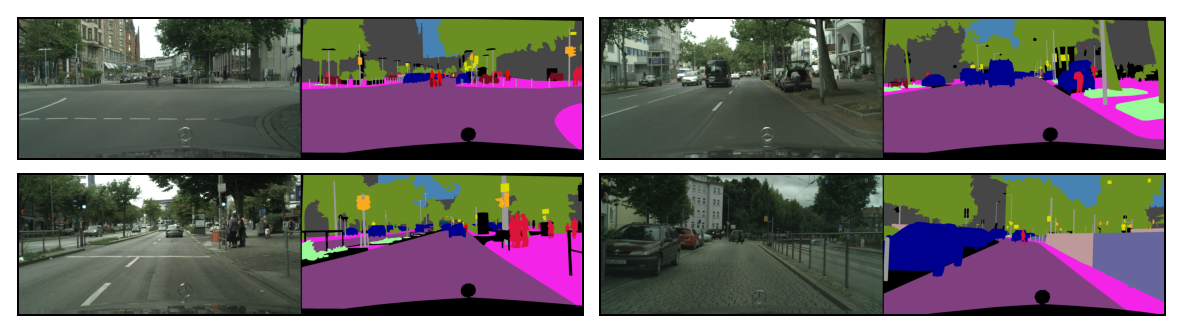

In [20]:
# Plot 4 random image-target pairs.

ixs: List[int] = ixs_shuffled[:4]
print(f"Random data indices chosen: {ixs}")

image_pairs: List[Tuple[np.ndarray, np.ndarray]] = []
for ix in ixs:
    filename_image: str = dataset.images[ix]
    filename_segmentation_map: str = dataset.targets[ix][0]
    image: np.ndarray = imageio.imread(filename_image)
    segmentation_map_int_raw: np.ndarray = \
        imageio.imread(filename_segmentation_map)
    segmentation_map_int: np.ndarray = \
        class_mapping.segmentation_map_int_from_raw(segmentation_map_int_raw)
    segmentation_map_rgb: np.ndarray = \
        class_mapping.segmentation_map_rgb_from_int(segmentation_map_int)
    image_pairs.append((image, segmentation_map_rgb))
images_for_plotting: List[np.ndarray] = \
    construct_segmentation_side_by_sides(image_pairs)

num_rows: int = 2
num_cols: int = 2
plot_grid_of_images(
    images_for_plotting,
    num_cols=num_cols,
    num_rows=num_rows,
    vertical_spacing=0.1,
    horizontal_spacing=0.03,
    show_image_boundaries=True,
)
plt.show()
# plt.savefig("cityscapes_examples.png", dpi=500)

---

## Validation Dataset Detailed Examination

In [21]:
dataset: Cityscapes = dataset_val
ixs_shuffled: List[int] = list(range(len(dataset)))
np.random.shuffle(ixs_shuffled)

In [22]:
# Collect and print image dimension statistics.
num_images_ubnd: int = 5000
num_images: int = min(num_images_ubnd, len(dataset))
image_filenames: List[str] = \
    [ dataset.images[ix] for ix in ixs_shuffled[:num_images] ]

start_time: float = time.time()
images_shape_stats: eda.ImagesShapeStats = \
    eda.ImagesShapeStats(image_filenames)
print(f"Examined dimensions of {num_images} images.")
print(f"Elapsed time = {time.time() - start_time:.2f} s")

images_shape_stats.print_summary()

Examined dimensions of 500 images.
Elapsed time = 4.82 s
+--------+--------+-------+-----------------------------+
|        | height | width | aspect ratio (width:height) |
+========+========+=======+=============================+
|   mean |  1024  | 2048  |              2              |
+--------+--------+-------+-----------------------------+
| median |  1024  | 2048  |              2              |
+--------+--------+-------+-----------------------------+
|    min |  1024  | 2048  |              2              |
+--------+--------+-------+-----------------------------+
|    max |  1024  | 2048  |              2              |
+--------+--------+-------+-----------------------------+


Random data index chosen: 170
/home/karl/karl/fast-karl/git_repos/image-segmentation-with-sparse-labels/data/cityscapes/leftImg8bit/val/munster/munster_000046_000019_leftImg8bit.png
type: <class 'numpy.ndarray'>
dtype: uint8
shape: (1024, 2048, 3)


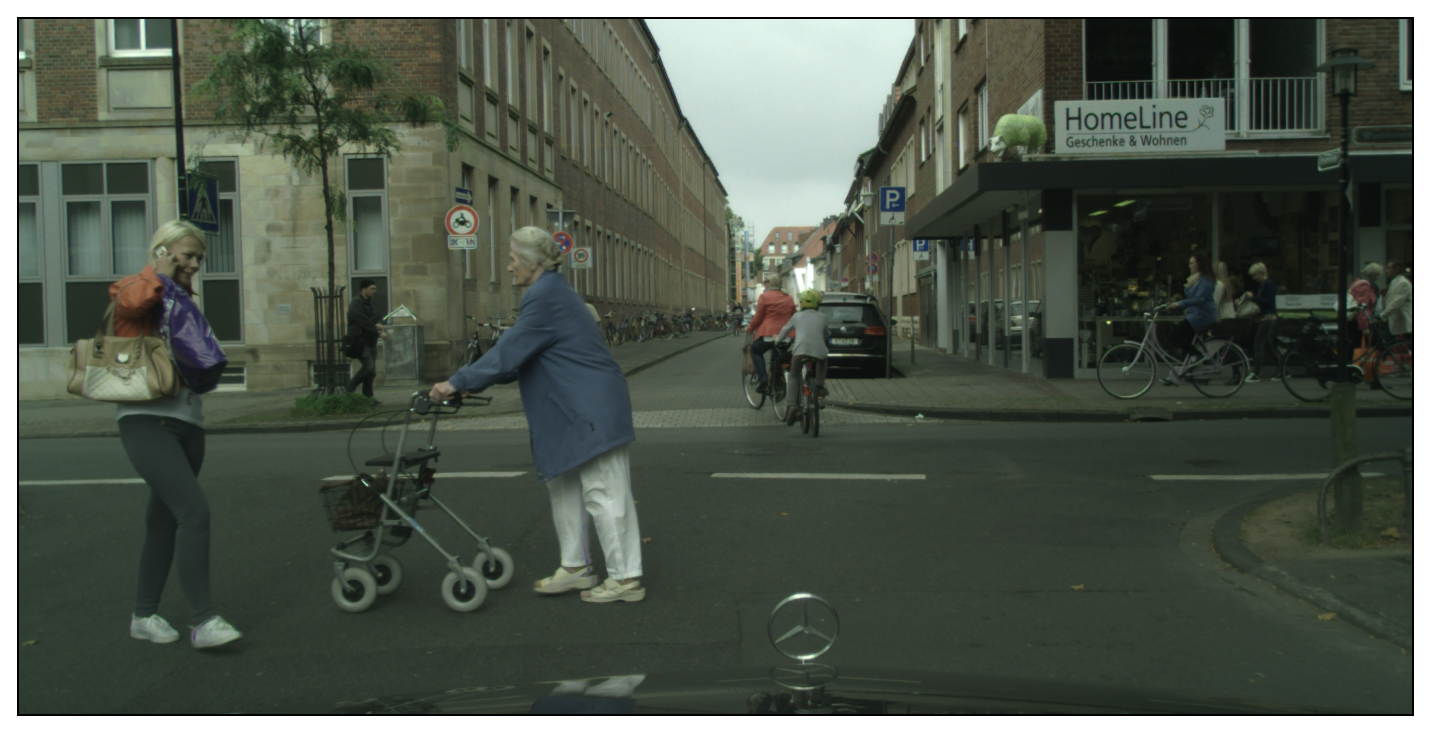

In [23]:
# Plot a random image.

ix: int = ixs_shuffled[0]
print(f"Random data index chosen: {ix}")

image_filename: str = dataset.images[ix]
print(image_filename)
image: np.ndarray = imageio.imread(image_filename)
eda.print_image_metadata(image)
show_image(image)

/home/karl/karl/fast-karl/git_repos/image-segmentation-with-sparse-labels/data/cityscapes/gtFine/val/munster/munster_000046_000019_gtFine_labelIds.png
type: <class 'numpy.ndarray'>
dtype: uint8
shape: (1024, 2048, 3)


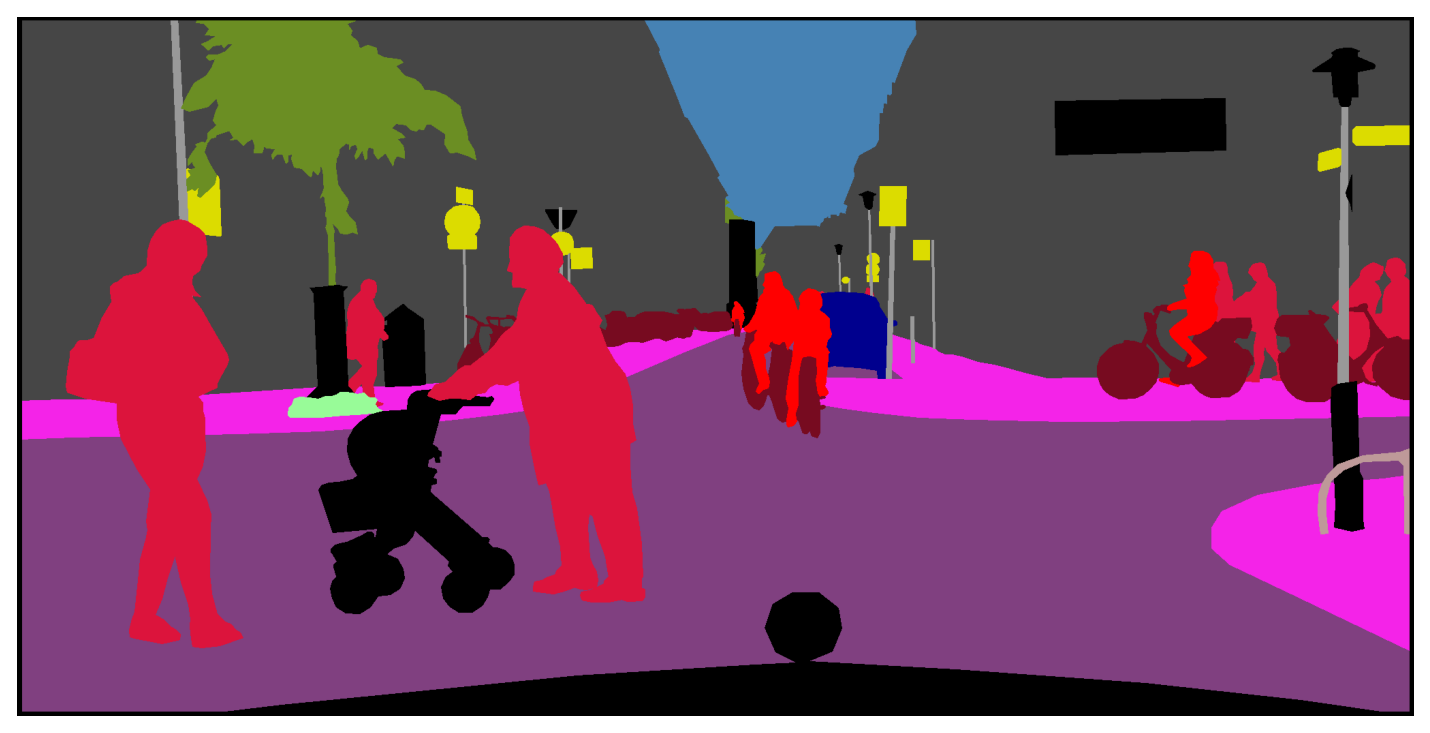

In [24]:
# Load and plot segmentation map from targets.

# Cityscapes raw mask pixels are segmentation class IDs (not RGB).
target_filename: str = dataset.targets[ix][0]

segmentation_map_int_raw: np.ndarray = imageio.imread(target_filename)
segmentation_map_int: np.ndarray = \
    class_mapping.segmentation_map_int_from_raw(segmentation_map_int_raw)
segmentation_map_rgb: np.ndarray = \
    class_mapping.segmentation_map_rgb_from_int(segmentation_map_int)

print(target_filename)
eda.print_image_metadata(segmentation_map_rgb)
show_image(segmentation_map_rgb)

In [25]:
# Collect and print raw segmentation class statistics from the targets.

num_images_ubnd: int = 5000
num_images: int = min(num_images_ubnd, len(dataset))
filenames: List[str] = \
    [ dataset.targets[ix][0] for ix in ixs_shuffled[:num_images] ]

start_time: float = time.time()
segmentation_maps_joint_pixel_stats: eda.SegmentationMapsJointPixelStats = \
    eda.SegmentationMapsJointPixelStats(
        segmentation_map_filenames=filenames,
        segmentation_map_int_from_raw=None,
    )
print(f"Examined the pixel labels of {num_images} images.")
print(f"Elapsed time = {time.time() - start_time:.2f} s")

class_id_names: Dict[SemanticClassId, str] = {
    class_.id: class_.name  for class_ in dataset.classes
}
segmentation_maps_joint_pixel_stats.print_summary(class_id_names)

Examined the pixel labels of 500 images.
Elapsed time = 19.62 s
+----------+--------------------+-----------+----------+-----------+-----------+
| class ID |     class name     | # pixels  | # images |  portion  |  portion  |
|          |                    |           |          | of pixels | of images |
+==========+====================+===========+==========+===========+===========+
|    0     |     unlabeled      |  375854   |    93    |   0.000   |   0.186   |
+----------+--------------------+-----------+----------+-----------+-----------+
|    1     |    ego vehicle     | 51330054  |   500    |   0.049   |     1     |
+----------+--------------------+-----------+----------+-----------+-----------+
|    2     |   rectification    | 19784166  |   267    |   0.019   |   0.534   |
|          |       border       |           |          |           |           |
+----------+--------------------+-----------+----------+-----------+-----------+
|    3     |     out of roi     | 15817000  |

In [26]:
#class_names = [ class_.name for class_ in dataset.classes ]
len(dataset.classes)
for class_ in dataset.classes:
    print(class_.id, class_.name, " ",  class_.color)
pprint(dataset.classes[0])

0 unlabeled   (0, 0, 0)
1 ego vehicle   (0, 0, 0)
2 rectification border   (0, 0, 0)
3 out of roi   (0, 0, 0)
4 static   (0, 0, 0)
5 dynamic   (111, 74, 0)
6 ground   (81, 0, 81)
7 road   (128, 64, 128)
8 sidewalk   (244, 35, 232)
9 parking   (250, 170, 160)
10 rail track   (230, 150, 140)
11 building   (70, 70, 70)
12 wall   (102, 102, 156)
13 fence   (190, 153, 153)
14 guard rail   (180, 165, 180)
15 bridge   (150, 100, 100)
16 tunnel   (150, 120, 90)
17 pole   (153, 153, 153)
18 polegroup   (153, 153, 153)
19 traffic light   (250, 170, 30)
20 traffic sign   (220, 220, 0)
21 vegetation   (107, 142, 35)
22 terrain   (152, 251, 152)
23 sky   (70, 130, 180)
24 person   (220, 20, 60)
25 rider   (255, 0, 0)
26 car   (0, 0, 142)
27 truck   (0, 0, 70)
28 bus   (0, 60, 100)
29 caravan   (0, 0, 90)
30 trailer   (0, 0, 110)
31 train   (0, 80, 100)
32 motorcycle   (0, 0, 230)
33 bicycle   (119, 11, 32)
-1 license plate   (0, 0, 142)
CityscapesClass(name='unlabeled', id=0, train_id=255, category

Random data indices chosen: [170, 118, 129, 381]


<Figure size 1800x1800 with 0 Axes>

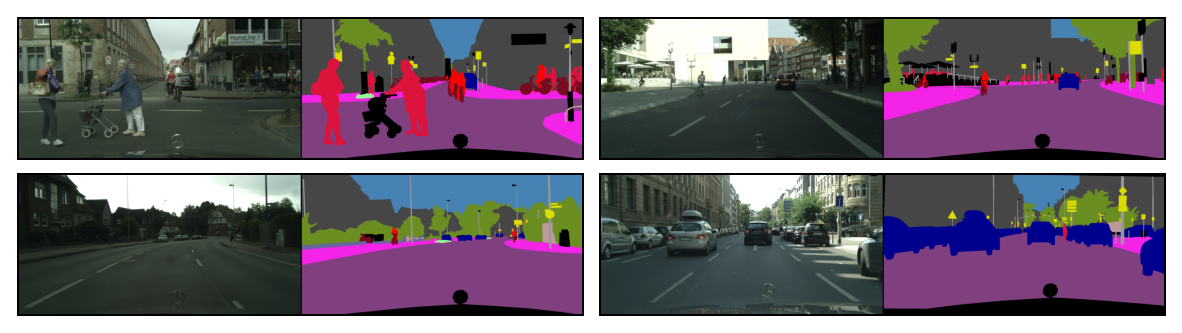

In [27]:
# Plot 4 random image-target pairs.

ixs: List[int] = ixs_shuffled[:4]
print(f"Random data indices chosen: {ixs}")

image_pairs: List[Tuple[np.ndarray, np.ndarray]] = []
for ix in ixs:
    filename_image: str = dataset.images[ix]
    filename_segmentation_map: str = dataset.targets[ix][0]
    image: np.ndarray = imageio.imread(filename_image)
    segmentation_map_int_raw: np.ndarray = \
        imageio.imread(filename_segmentation_map)
    segmentation_map_int: np.ndarray = \
        class_mapping.segmentation_map_int_from_raw(segmentation_map_int_raw)
    segmentation_map_rgb: np.ndarray = \
        class_mapping.segmentation_map_rgb_from_int(segmentation_map_int)
    image_pairs.append((image, segmentation_map_rgb))
images_for_plotting: List[np.ndarray] = \
    construct_segmentation_side_by_sides(image_pairs)

num_rows: int = 2
num_cols: int = 2
plot_grid_of_images(
    images_for_plotting,
    num_cols=num_cols,
    num_rows=num_rows,
    vertical_spacing=0.1,
    horizontal_spacing=0.03,
    show_image_boundaries=True,
)
plt.show()
# plt.savefig("cityscapes_examples.png", dpi=500)

---

## Test Dataset Detailed Examination

In [28]:
dataset: Cityscapes = dataset_test
ixs_shuffled: List[int] = list(range(len(dataset)))
np.random.shuffle(ixs_shuffled)

In [29]:
# Collect and print image dimension statistics.
num_images_ubnd: int = 5000
num_images: int = min(num_images_ubnd, len(dataset))
image_filenames: List[str] = \
    [ dataset.images[ix] for ix in ixs_shuffled[:num_images] ]

start_time: float = time.time()
images_shape_stats: eda.ImagesShapeStats = \
    eda.ImagesShapeStats(image_filenames)
print(f"Examined dimensions of {num_images} images.")
print(f"Elapsed time = {time.time() - start_time:.2f} s")

images_shape_stats.print_summary()

Examined dimensions of 1525 images.
Elapsed time = 14.11 s
+--------+--------+-------+-----------------------------+
|        | height | width | aspect ratio (width:height) |
+========+========+=======+=============================+
|   mean |  1024  | 2048  |              2              |
+--------+--------+-------+-----------------------------+
| median |  1024  | 2048  |              2              |
+--------+--------+-------+-----------------------------+
|    min |  1024  | 2048  |              2              |
+--------+--------+-------+-----------------------------+
|    max |  1024  | 2048  |              2              |
+--------+--------+-------+-----------------------------+


Random data index chosen: 260
/home/karl/karl/fast-karl/git_repos/image-segmentation-with-sparse-labels/data/cityscapes/leftImg8bit/test/munich/munich_000275_000019_leftImg8bit.png
type: <class 'numpy.ndarray'>
dtype: uint8
shape: (1024, 2048, 3)


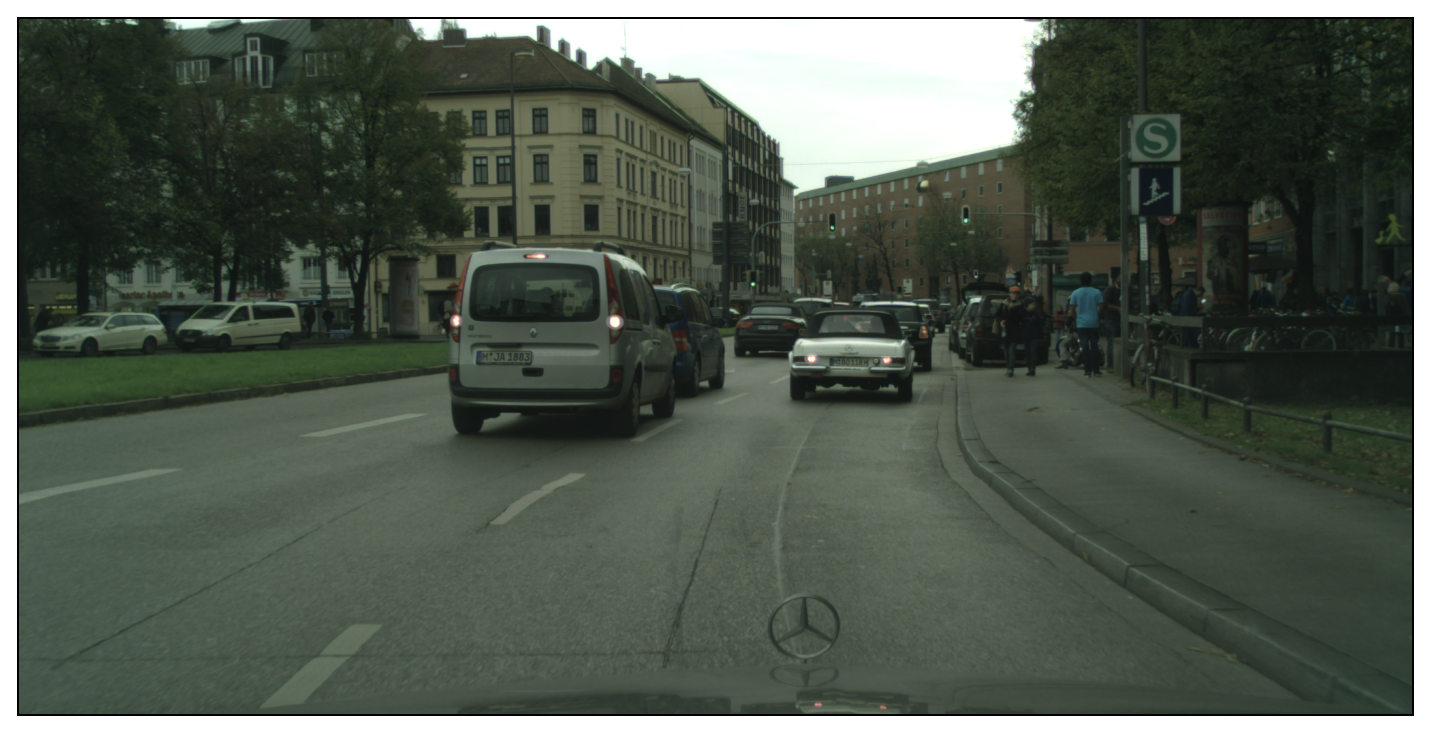

In [30]:
# Plot a random image.

ix: int = ixs_shuffled[0]
print(f"Random data index chosen: {ix}")

image_filename: str = dataset.images[ix]
print(image_filename)
image: np.ndarray = imageio.imread(image_filename)
eda.print_image_metadata(image)
show_image(image)

/home/karl/karl/fast-karl/git_repos/image-segmentation-with-sparse-labels/data/cityscapes/gtFine/test/munich/munich_000275_000019_gtFine_labelIds.png
type: <class 'numpy.ndarray'>
dtype: uint8
shape: (1024, 2048, 3)


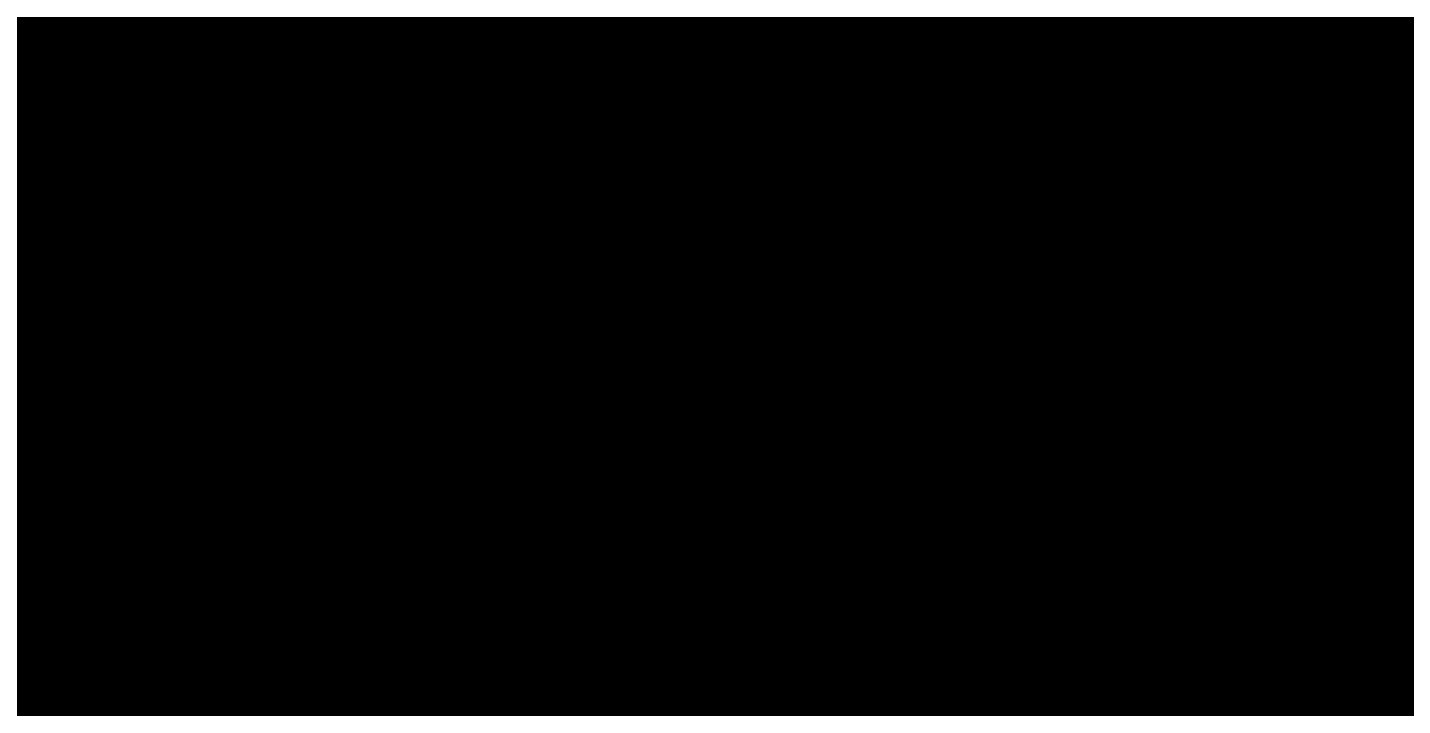

In [31]:
# Load and plot segmentation map from targets.

# Cityscapes raw mask pixels are segmentation class IDs (not RGB).
target_filename: str = dataset.targets[ix][0]

segmentation_map_int_raw: np.ndarray = imageio.imread(target_filename)
segmentation_map_int: np.ndarray = \
    class_mapping.segmentation_map_int_from_raw(segmentation_map_int_raw)
segmentation_map_rgb: np.ndarray = \
    class_mapping.segmentation_map_rgb_from_int(segmentation_map_int)

print(target_filename)
eda.print_image_metadata(segmentation_map_rgb)
show_image(segmentation_map_rgb)

In [32]:
# Collect and print raw segmentation class statistics from the targets.

# The entire training set contains exactly the raw class IDs [0, 1, 2,..., 33].
# Running with `num_images_ubnd=500` gives at least 1 example of each.
num_images_ubnd: int = 5000
num_images: int = min(num_images_ubnd, len(dataset))
filenames: List[str] = \
    [ dataset.targets[ix][0] for ix in ixs_shuffled[:num_images] ]

start_time: float = time.time()
segmentation_maps_joint_pixel_stats: eda.SegmentationMapsJointPixelStats = \
    eda.SegmentationMapsJointPixelStats(
        segmentation_map_filenames=filenames,
        segmentation_map_int_from_raw=None,
    )
print(f"Examined the pixel labels of {num_images} images.")
print(f"Elapsed time = {time.time() - start_time:.2f} s")

class_id_names: Dict[SemanticClassId, str] = {
    class_.id: class_.name  for class_ in dataset.classes
}
segmentation_maps_joint_pixel_stats.print_summary(class_id_names)

Examined the pixel labels of 1525 images.
Elapsed time = 58.51 s
+----------+--------------------+-----------+----------+-----------+-----------+
| class ID |     class name     | # pixels  | # images |  portion  |  portion  |
|          |                    |           |          | of pixels | of images |
+==========+====================+===========+==========+===========+===========+
|    0     |     unlabeled      | 2.971e+09 |   1525   |   0.929   |     1     |
+----------+--------------------+-----------+----------+-----------+-----------+
|    1     |    ego vehicle     | 1.433e+08 |   1525   |   0.045   |     1     |
+----------+--------------------+-----------+----------+-----------+-----------+
|    2     |   rectification    | 35492942  |   479    |   0.011   |   0.314   |
|          |       border       |           |          |           |           |
+----------+--------------------+-----------+----------+-----------+-----------+
|    3     |     out of roi     | 48241850  

In [33]:
#class_names = [ class_.name for class_ in dataset.classes ]
len(dataset.classes)
for class_ in dataset.classes:
    print(class_.id, class_.name, " ",  class_.color)
pprint(dataset.classes[0])

0 unlabeled   (0, 0, 0)
1 ego vehicle   (0, 0, 0)
2 rectification border   (0, 0, 0)
3 out of roi   (0, 0, 0)
4 static   (0, 0, 0)
5 dynamic   (111, 74, 0)
6 ground   (81, 0, 81)
7 road   (128, 64, 128)
8 sidewalk   (244, 35, 232)
9 parking   (250, 170, 160)
10 rail track   (230, 150, 140)
11 building   (70, 70, 70)
12 wall   (102, 102, 156)
13 fence   (190, 153, 153)
14 guard rail   (180, 165, 180)
15 bridge   (150, 100, 100)
16 tunnel   (150, 120, 90)
17 pole   (153, 153, 153)
18 polegroup   (153, 153, 153)
19 traffic light   (250, 170, 30)
20 traffic sign   (220, 220, 0)
21 vegetation   (107, 142, 35)
22 terrain   (152, 251, 152)
23 sky   (70, 130, 180)
24 person   (220, 20, 60)
25 rider   (255, 0, 0)
26 car   (0, 0, 142)
27 truck   (0, 0, 70)
28 bus   (0, 60, 100)
29 caravan   (0, 0, 90)
30 trailer   (0, 0, 110)
31 train   (0, 80, 100)
32 motorcycle   (0, 0, 230)
33 bicycle   (119, 11, 32)
-1 license plate   (0, 0, 142)
CityscapesClass(name='unlabeled', id=0, train_id=255, category

Random data indices chosen: [260, 542, 1384, 1516]


<Figure size 1800x1800 with 0 Axes>

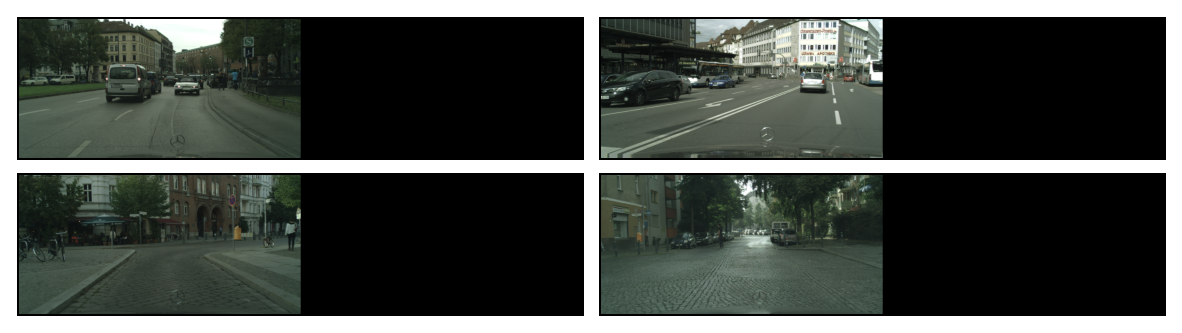

In [34]:
# Plot 4 random image-target pairs.
# These targets are black because the true targets are kept secret
# for use only by the Cityscapes test server.

ixs: List[int] = ixs_shuffled[:4]
print(f"Random data indices chosen: {ixs}")

image_pairs: List[Tuple[np.ndarray, np.ndarray]] = []
for ix in ixs:
    filename_image: str = dataset.images[ix]
    filename_segmentation_map: str = dataset.targets[ix][0]
    image: np.ndarray = imageio.imread(filename_image)
    segmentation_map_int_raw: np.ndarray = \
        imageio.imread(filename_segmentation_map)
    segmentation_map_int: np.ndarray = \
        class_mapping.segmentation_map_int_from_raw(segmentation_map_int_raw)
    segmentation_map_rgb: np.ndarray = \
        class_mapping.segmentation_map_rgb_from_int(segmentation_map_int)
    image_pairs.append((image, segmentation_map_rgb))
images_for_plotting: List[np.ndarray] = \
    construct_segmentation_side_by_sides(image_pairs)

num_rows: int = 2
num_cols: int = 2
plot_grid_of_images(
    images_for_plotting,
    num_cols=num_cols,
    num_rows=num_rows,
    vertical_spacing=0.1,
    horizontal_spacing=0.03,
    show_image_boundaries=True,
)
plt.show()
# plt.savefig("cityscapes_examples.png", dpi=500)